# Classes Report Binary

## Library Import

In [1]:
import pandas as pd
import joblib
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import preprocess_text
from utils.bad_word_blurrer import blur_text
from utils.frequent_pattern import get_itemsets
import warnings

## Dataset Vectorization and PatternMining Preparation

In [2]:
df = pd.read_csv("../dataset/training_set.csv")
df["text"] = df["text"].apply(preprocess_text)

pipeline = joblib.load("../model/binary/RandomForest_TF-IDF.pkl")
vectorizer = pipeline.named_steps["vectorizer"]

X_tfidf = vectorizer.transform(df['text'])
X_tfidf = (X_tfidf > 0).astype(int)

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df["binary_label"] = df["binary_label"].values



## Frequent terms & associations mining

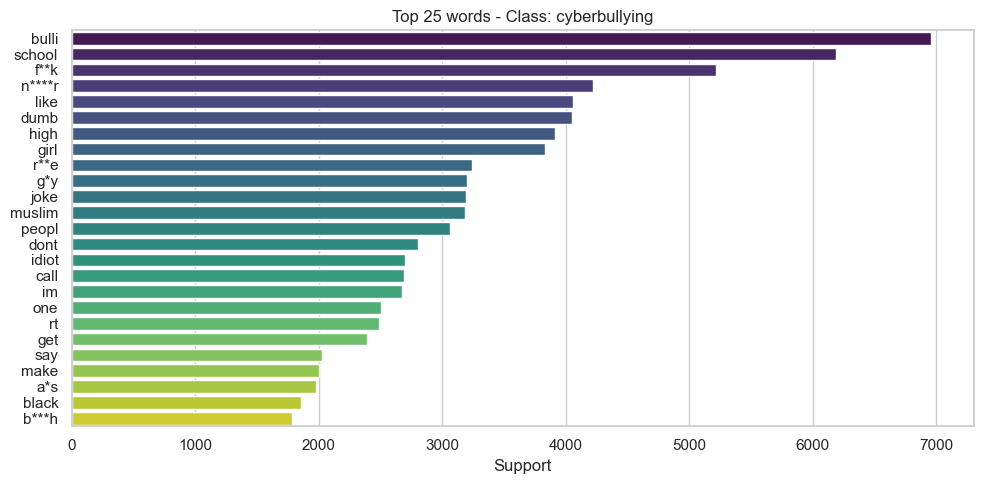

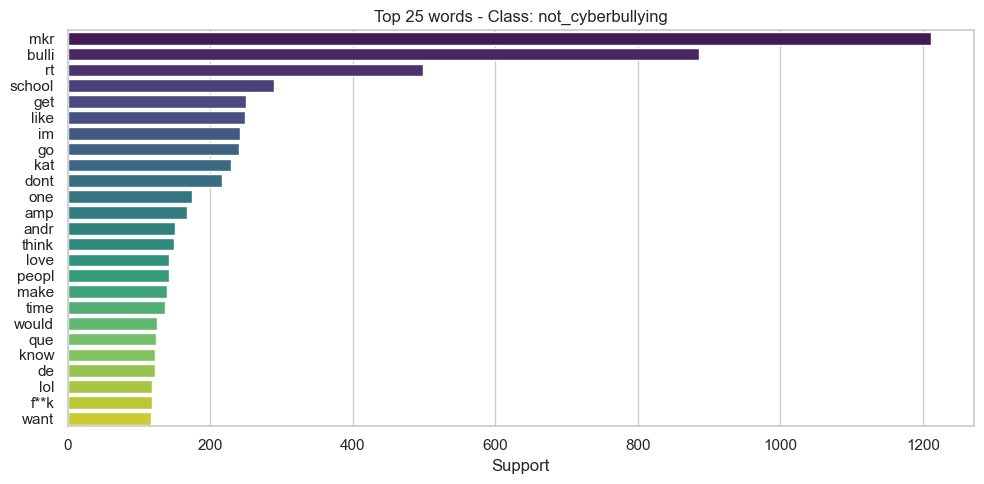

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

classes = tfidf_df['binary_label'].unique()
closed_by_class = {}
maximal_by_class = {}

sns.set(style="whitegrid")

for cla in classes:
    class_df = tfidf_df[tfidf_df['binary_label'] == cla].drop(columns=['binary_label'])

    word_support = class_df.sum().sort_values(ascending=False).head(25)
    blurred_index = [blur_text(word) for word in word_support.index]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=word_support.values, y=blurred_index, palette="viridis")
    plt.title(f"Top 25 words - Class: {cla}")
    plt.xlabel("Support")
    plt.tight_layout()

    safe_class = cla.replace("/", "-")
    filename = f"../word_class_distribution/top_25_{safe_class}.png"
    plt.savefig(filename)
    plt.show()

    frequent_itemsets = apriori(class_df, min_support=0.05, use_colnames=True)
    closed_sets = get_itemsets(frequent_itemsets,'closed')
    maximal_sets = get_itemsets(frequent_itemsets,'maximal')

    closed_by_class[cla] = closed_sets
    maximal_by_class[cla] = maximal_sets


## Rules Formatting for Interpretability

In [4]:
# CLOSED
closed_rows = []
for cla, df in closed_by_class.items():
    for _, row in df.iterrows():
        closed_rows.append({
            'class': cla,
            'itemset': ', '.join(row['itemsets']),
            'support': row['support']
        })

closed_df = pd.DataFrame(closed_rows)
closed_df.to_csv("../itemset/closed_itemsets_by_class_binary.csv", index=False)

# MAXIMAL
maximal_rows = []
for cla, df in maximal_by_class.items():
    for _, row in df.iterrows():
        maximal_rows.append({
            'class': cla,
            'itemset': ', '.join(row['itemsets']),
            'support': row['support']
        })

maximal_df = pd.DataFrame(maximal_rows)
maximal_df.to_csv("../itemset/maximal_itemsets_by_class_binary.csv", index=False)

print("Distribution CLOSED itemsets:")
print(closed_df['class'].value_counts())
print("\nDistribution MAXIMAL itemsets:")
print(maximal_df['class'].value_counts())


Distribution CLOSED itemsets:
class
cyberbullying        54
not_cyberbullying     4
Name: count, dtype: int64

Distribution MAXIMAL itemsets:
class
cyberbullying        23
not_cyberbullying     4
Name: count, dtype: int64
